In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, datasets, models
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

## Prepare Dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

The above line of code downloads and loads the MNIST dataset from TensorFlow's built-in datasets. The dataset is automatically split into training and testing subsets. The unpacking assigns:

train_images — 60,000 training images of handwritten digits

train_labels — 60,000 corresponding digit labels (0-9)

test_images — 10,000 test images for evaluation

test_labels — 10,000 corresponding test labels

Initial Shape: Images are loaded as grayscale with shape (60000, 28, 28) and (10000, 28, 28) respectively, where 28×28 represents pixel dimensions.

In [4]:
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

TThe above line of code, reshape the images from 3D arrays to 4D arrays by adding a channel dimension. The reshape operation transforms:

From: (60000, 28, 28) — height, width only

To: (60000, 28, 28, 1) — height, width, channels (1 for grayscale)

The final dimension of 1 represents a single color channel, which is required by convolutional neural networks. Color images would have 3 channels (RGB), but MNIST contains grayscale images with only 1 channel.

In [5]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

The above line of code performs min-max normalization on pixel values. MNIST images have pixel intensities ranging from 0 to 255 (standard for 8-bit images). Dividing by 255.0 scales all values to the range [0, 1].

In [6]:
print("TRAIN IMAGES: ", train_images.shape)
print("TEST IMAGES: ", test_images.shape)

TRAIN IMAGES:  (60000, 28, 28, 1)
TEST IMAGES:  (10000, 28, 28, 1)


## Create Model

In [7]:
num_classes = 10
img_height = 28
img_width = 28

model = Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

## Compile Model

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 64)       │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,154 (422.48 KB)

 Trainable params: 108,154 (422.48 KB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [10]:
epochs = 10
history = model.fit(
  train_images, 
  train_labels,
  epochs = epochs,
  validation_split=0.1
)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.9528 - loss: 0.1516 - val_accuracy: 0.9838 - val_loss: 0.0564
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.9846 - loss: 0.0489 - val_accuracy: 0.9893 - val_loss: 0.0388
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9888 - loss: 0.0369 - val_accuracy: 0.9913 - val_loss: 0.0298
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9908 - loss: 0.0279 - val_accuracy: 0.9847 - val_loss: 0.0668
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.9926 - loss: 0.0240 - val_accuracy: 0.9903 - val_loss: 0.0341
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9937 - loss: 0.0197 - val_accuracy: 0.9917 - val_loss: 0.0317
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.9945 - loss: 0.0170 - val_accuracy: 0.9922 - val_loss: 0.0291
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.9956 -

## Visualize Training Results

Text(0.5, 1.0, 'Training Accuracy and Loss')

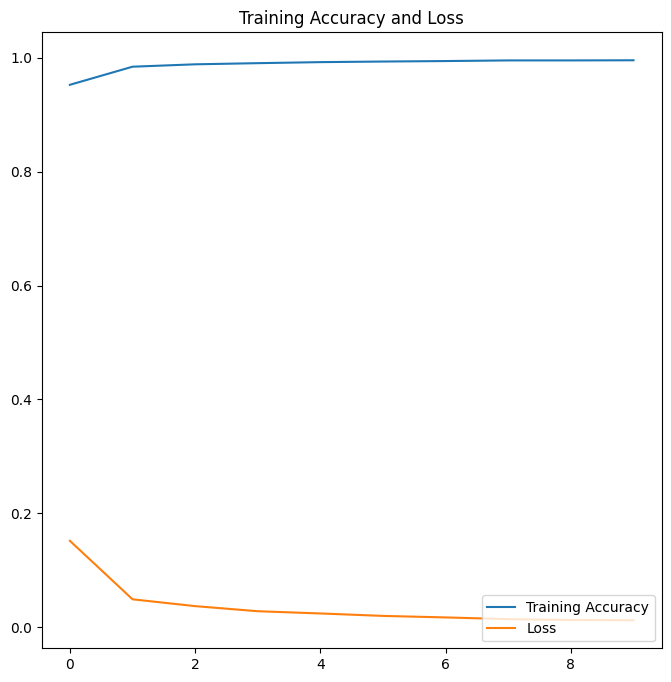

In [11]:
acc = history.history['accuracy']
loss=history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, loss, label='Loss')
plt.legend(loc='lower right')
plt.title('Training Accuracy and Loss')

The above code creates a comprehensive visualization of the model's training performance by plotting accuracy and loss metrics across all training epochs.

## Test Image

Prediction of model: 0


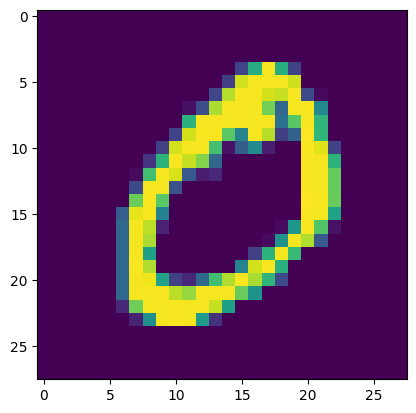

In [12]:
image = (train_images[1]).reshape(1,28,28,1)
model_pred = model.predict(image, verbose=0)
plt.imshow(image.reshape(28,28))
print('Prediction of model: {}'.format(np.argmax(model_pred[0])))

Prediction of model: 4


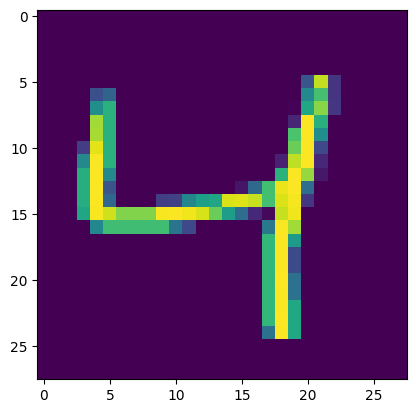

In [13]:
image = (train_images[2]).reshape(1,28,28,1)
model_pred = model.predict(image, verbose=0)
plt.imshow(image.reshape(28,28))
print('Prediction of model: {}'.format(np.argmax(model_pred[0])))

## Test Multiple Image

Test images array shape: (4, 28, 28)
Predicted digit: 2
Predicted digit: 1
Predicted digit: 0
Predicted digit: 4


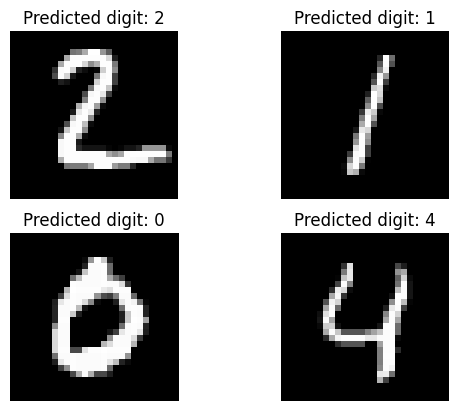

In [14]:
images = test_images[1:5]
images = images.reshape(images.shape[0], 28, 28)
print ("Test images array shape: {}".format(images.shape))


for i, test_image in enumerate(images, start=1):

    org_image = test_image
    test_image = test_image.reshape(1,28,28,1)
    prediction = model.predict(test_image, verbose=0)

    print ("Predicted digit: {}".format(np.argmax(prediction[0])))
    plt.subplot(220+i)
    plt.axis('off')
    plt.title("Predicted digit: {}".format(np.argmax(prediction[0])))
    plt.imshow(org_image, cmap=plt.get_cmap('gray'))

plt.show()

## Save Model

In [15]:
model.save("tf-cnn-model.h5")

## Load Model

In [16]:
loaded_model = models.load_model("tf-cnn-model.h5")

Prediction of model: 4


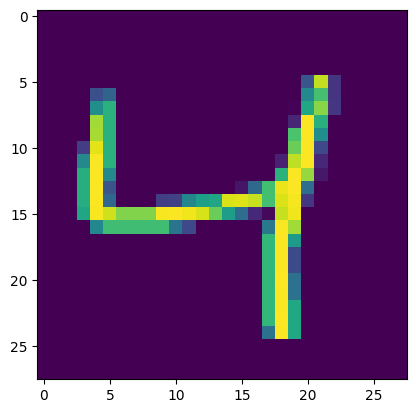

In [17]:
image = (train_images[2]).reshape(1,28,28,1)
model_pred = loaded_model.predict(image, verbose=0)
plt.imshow(image.reshape(28,28))
print('Prediction of model: {}'.format(np.argmax(model_pred[0])))

Building this MNIST CNN project likely involved several challenges across data handling, model design, training, and deployment.​

Data and preprocessing
Understanding the MNIST data format and reshaping from 
(
60000
,
28
,
28
)
(60000,28,28) to 
(
60000
,
28
,
28
,
1
)
(60000,28,28,1) for CNN input can be confusing at first.​

Choosing and applying normalization (dividing by 255.0) while making sure label formats still match the chosen loss function is another common hurdle.​

Model design and tuning
Selecting the number of Conv2D, MaxPooling2D, and Dense layers, and balancing model complexity with overfitting risk requires experimentation.​

Matching the final activation (sigmoid vs softmax) with SparseCategoricalCrossentropy(from_logits=True) and understanding logits vs probabilities can be tricky.​

Training, evaluation, and saving
Interpreting training curves (accuracy vs loss), choosing epochs, and avoiding under/overfitting needs iteration and judgment.​

Correctly saving to HDF5, reloading the model, and handling warnings about legacy formats are practical deployment challenges.